Author: mobin habibpour 

> mobin.habibpour@gmail.com

> 98210727

Course Project: Estimating Systolic and Diastolic Blood Pressure Using Photoplethysmogram (PPG) signals



Course: Statistical Learning

Supervisor: Dr.Mohammdadzade

Department of Electrical Engineering 

Sharif Uni. of Tech.



#Section_1

####Dataset importing and visualization

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

!gdown --id 1PIFece8Cxy9Q65N_IJ3nbfAOWHH8y_Pa
!gdown --id 1DigjkwWCwyjBUGg84HCU9mm5UWwmnfID

# importing data
data_train = np.load('s1_train.npy', allow_pickle=True)
X_train = data_train[:,0]
y_train = data_train[:,1]

y_train = np.stack(y_train).astype(None)

data_test = np.load('s1_test.npy', allow_pickle=True)
X_test = data_test[:,0]

del data_test ,data_train

Downloading...
From: https://drive.google.com/uc?id=1PIFece8Cxy9Q65N_IJ3nbfAOWHH8y_Pa
To: /content/s1_train.npy
100% 1.37M/1.37M [00:00<00:00, 8.40MB/s]
Downloading...
From: https://drive.google.com/uc?id=1DigjkwWCwyjBUGg84HCU9mm5UWwmnfID
To: /content/s1_test.npy
100% 144k/144k [00:00<00:00, 1.27MB/s]


visualizing couple of the PPG signal data

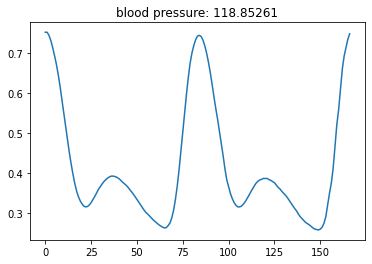

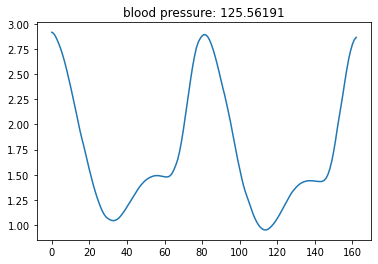

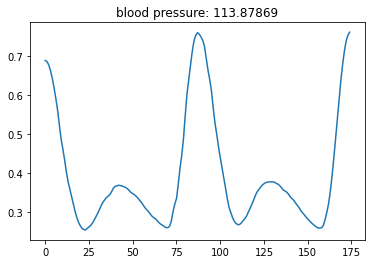

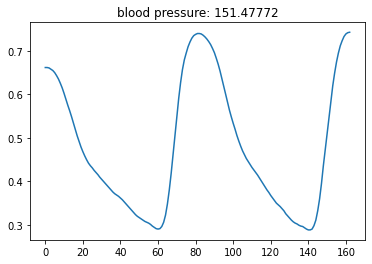

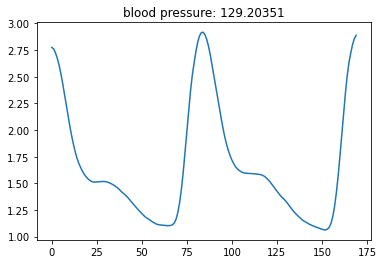

In [ ]:
for i in np.arange(0,100,20):
  plt.plot(range(len(X_train[i])), X_train[i])
  plt.title(f'blood pressure: {y_train[i]:.5f}')
  plt.show()


####Baseline model

In [ ]:
# only fitting an intercept (mean of the output)

y = y_train.mean()
print('intercept:',y)

TSS = 0
ae = 0
for i in range(len(y_train)):
  TSS += (y_train[i] - y)**2
  ae += abs(y_train[i] - y)

baseline = TSS/len(y_train)
print('mean squared error on train data:', baseline)
# print('mean absolute error on train data:',ae/len(y_train))

def improvement(base, new):
  print('improvement over baseline model: %.2f percent'  %((base - new)/base * 100))

intercept: 131.069949819987
mean squared error on train data: 660.9802299962232


####PCA

zero-padding the data rows to have equal size

In [ ]:
def zero_pad(dataset):
  row_lengths = []
  for row in dataset:
      row_lengths.append(len(row))

  max_length = max(row_lengths)

  for idx ,array in enumerate(dataset):
    while len(array) < max_length:
      array = np.append(array,0)
    dataset[idx] = array

  dataset = np.vstack(dataset).astype(None)
  return dataset

X_train = zero_pad(X_train)
X_test = zero_pad(X_test)

performing dimension reduction PCA on data

In [ ]:
from sklearn import decomposition
from sklearn.preprocessing import StandardScaler

def PCA_(data, dimension):
  # normalizig the data for pca
  data = StandardScaler().fit_transform(data)

  pca = decomposition.PCA()

  pca.n_components = dimension
  return pca.fit_transform(data)

print("shape of train data before pca= ", X_train.shape)
print("shape of test data before pca= ", X_test.shape)

X_train = PCA_(X_train, 95)
X_test = PCA_(X_test, 95)

print("shape of train data after pca= ", X_train.shape)
print("shape of test data after pca= ", X_test.shape)

shape of train data before pca=  (1000, 199)
shape of test data before pca=  (100, 199)
shape of train data after pca=  (1000, 95)
shape of test data after pca=  (100, 95)


####Nested Cross Validation Model Selection

Here we add various regression algorithems and their corresponding hyperparameters to a dictionary, we run nested cross validation for each of the models and compare them. We search for the optimum hyper parameter in the inner CV and the outer CV estimates the models performance on test data. At last we run the inner CV for the best regressor model found and refit the model on the whole dataset.

In [ ]:
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.kernel_ridge import KernelRidge


# define polynomial regression pipeline
pipeline = make_pipeline(PolynomialFeatures(), LinearRegression())

##### Cross Validation
inner_cv = KFold(n_splits=10, shuffle=True, random_state=1) # validation
outer_cv = KFold(n_splits=10, shuffle=True, random_state=2) # test

# adding various regression models and their corresponding hyper parameters to a dictionary
models_and_parameters = {
    'svr': (SVR(),
            {'C': np.linspace(7,25,10, dtype=int)}),
    'rforest': (RandomForestRegressor(),
            {'max_depth': np.linspace(180,220,10, dtype=int)}),
    'ridge': (Ridge(),
            {'alpha': 10**np.linspace(10,-2,20)*0.5}),
    # 'dtree': (DecisionTreeRegressor(),
    #         {'max_depth': np.linspace(10,500,11, dtype=int)}),
    'gbr': (GradientBoostingRegressor(),
            {'max_depth': range(3,7),
            'n_estimators': np.linspace(100,250,5, dtype=int)}),
    'knr': (KNeighborsRegressor(),
            {'n_neighbors': np.linspace(8,15,8, dtype=int)}),
    # 'poly': (pipeline,
    #         {'polynomialfeatures__degree': range(1,4)})                     
            }
# poly and decision tree scores were waay off, consequently we don't run them

# we will collect the average of the scores on the outer folds in this dictionary
# with keys given by the names of the models as in 'models_and_parameters'
average_scores_across_outer_folds_for_each_model = dict()

# find the model with the best generalization error
for name, (model, params) in models_and_parameters.items():

    # choose best hyperparameters automatically using 'inner_cv'
    regressor_that_optimizes_hyperparams = GridSearchCV(estimator=model, 
                                                        param_grid=params,
                                                        cv=inner_cv, 
                                                        scoring='neg_mean_squared_error')
    
    # estimate generalization error using 'outer_cv'
    scores_across_outer_folds = cross_val_score(regressor_that_optimizes_hyperparams,
                                                X_train, y_train, cv=outer_cv, 
                                                scoring='neg_mean_squared_error')

    # get the mean MSE across each of outer_cv's folds
    average_scores_across_outer_folds_for_each_model[name] = np.mean(scores_across_outer_folds)

    error_summary = 'Model: {name}\nMSE in the outer folds: {scores}.\nAverage error: {avg}'
    print(error_summary.format(name=name, scores=scores_across_outer_folds,
                               avg=np.mean(scores_across_outer_folds)))
    print()

print('Average score across the outer folds: ',
      average_scores_across_outer_folds_for_each_model)


Model: svr
MSE in the outer folds: [-613.65391241 -720.13160015 -632.30669411 -515.33648105 -682.41055601
 -503.0448752  -824.0205953  -602.16108924 -581.63519398 -729.3628752 ].
Average error: -640.4063872631963

Model: rforest
MSE in the outer folds: [-519.40141882 -607.65548204 -536.9919106  -481.30302149 -581.51179076
 -435.16811889 -668.12958587 -543.44052691 -548.60210679 -649.37496035].
Average error: -557.1578922505736

Model: ridge
MSE in the outer folds: [-626.81363199 -647.88053529 -707.08290146 -530.40653443 -711.52130988
 -504.28519954 -793.13016176 -646.88627837 -651.98356548 -744.60812742].
Average error: -656.4598245640121

Model: gbr
MSE in the outer folds: [-540.79601198 -654.19631301 -526.52276052 -516.48060764 -680.01178136
 -516.86596205 -667.61841662 -565.21096682 -616.7083052  -647.62242586].
Average error: -593.2033551053795

Model: knr
MSE in the outer folds: [-587.15442053 -667.04293081 -573.50976072 -580.11627164 -648.83502773
 -491.32859373 -720.94095231 -60

now we refit this best model on the whole dataset so that we can start
making predictions on other data, and now we have a reliable estimate of
this model's generalization error and we are confident this is the best model
among the ones we have tried

In [ ]:
best_model_name, best_model_avg_score = max(average_scores_across_outer_folds_for_each_model.items(),
                                            key=(lambda name_averagescore: name_averagescore[1]))

# get the best model and its associated parameter grid
best_model, best_model_params = models_and_parameters[best_model_name]

final_regressor = GridSearchCV(best_model, best_model_params, cv=inner_cv)
final_regressor.fit(X_train, y_train)

print('Best model: \n\t{}'.format(best_model), end='\n\n')
print('Estimation of its generalization error (negative mean squared error):\n\t{}'.format(
    best_model_avg_score), end='\n\n')
print('Best parameter choice for this model: \n\t{params}'
      '\n(according to cross-validation `{cv}` on the whole dataset).'.format(
      params=final_regressor.best_params_, cv=inner_cv))

improvement(baseline, - best_model_avg_score)

Best model: 
	RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

Estimation of its generalization error (negative mean squared error):
	-557.1578922505736

Best parameter choice for this model: 
	{'max_depth': 215}
(according to cross-validation `KFold(n_splits=10, random_state=1, shuffle=True)` on the whole dataset).
improvement over baseline model: 15.71 percent


####Evaluating Best Model on Test Data

In [ ]:
s1_predicted = final_regressor.predict(X_test)
print(s1_predicted)
np.save('s1_predicted.npy', s1_predicted)

[129.55829191 125.95055955 130.53998697 127.0353346  127.83392107
 127.80642442 123.48749265 123.29679783 123.28098051 125.07122631
 127.91932841 125.48965079 119.59500495 123.60787539 127.23181837
 121.10676771 125.17875377 118.90422912 121.6178848  121.84593454
 132.89381497 126.04390123 129.01186541 135.60982762 129.03312656
 129.05792533 125.50410481 135.06178517 119.71907143 126.19716512
 123.94511407 119.97075665 125.47049835 127.49368272 124.47170889
 129.75615577 124.10494911 125.30538455 127.06005644 124.04881206
 121.0623762  124.19422964 128.26265814 130.79106006 125.30621688
 129.1720464  121.62299595 129.13766262 120.58517773 133.38395067
 128.35722373 125.08079648 127.41986854 121.81508773 124.8467116
 122.48301715 126.03264583 125.05134254 127.02416681 120.51339458
 120.26427662 125.98611053 119.82267486 127.02395662 133.98976651
 131.17122917 123.18901615 121.96153916 130.5004218  125.15186055
 125.06460499 126.32339511 125.68341407 122.99498966 122.86309351
 125.476613

#Section_2

#### Dataset Import

In [43]:
import numpy as np
import matplotlib.pyplot as plt

!gdown --id 1ytV9Ywo3YVJcLMuA4oi9RU1IIU_fj8Hd
!gdown --id 17bd6TXtSCwN0prwvqp7Gz5kVtRcjM75d

# importing data
data_train = np.load('s2_train.npy', allow_pickle=True)
ppg = data_train[:,0] # ppg signal of training samples
bp = data_train[:,1] # blood pressure signal of training samples

data_test = np.load('s2_test.npy', allow_pickle=True)
ppg_test = data_test[:,0]

del data_test ,data_train

Downloading...
From: https://drive.google.com/uc?id=1ytV9Ywo3YVJcLMuA4oi9RU1IIU_fj8Hd
To: /content/s2_test.npy
2.70MB [00:00, 66.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=17bd6TXtSCwN0prwvqp7Gz5kVtRcjM75d
To: /content/s2_train.npy
54.0MB [00:00, 148MB/s] 


#### Data Preprocessing

We first split the training data to 10 pulse in each sample, then we deal with noisy and corrupted samples in consequent sections

In [44]:
from scipy.signal import find_peaks
import scipy.signal

X_train = []
y_systolic_train = []
y_diastolic_train = []
blood_pressure = []
previous = 0

# finding peaks in the input data in order to split the training data
for s in range(ppg.shape[0]):

  # searches for critical points higher than 2 with minimun distance of 40
  peaks, _ = find_peaks(ppg[s], height=2, distance=40)

  for idx, p in enumerate(peaks):
    # uding the found peaks cordinates to split the data
    if idx % 10 == 0 and not idx==0:
      if idx == 10:
        previous = 0
      
      X_train.append(ppg[s][previous:p])
      blood_pressure.append(bp[s][previous:p])

      # since the optimum height for finding the peaks might be different in each sample
      # we perform the peak finding two times, this way the second peak finder has better 
      # estimate of the height of the peaks in the specific sample

      _, height_ = find_peaks(bp[s][previous:p], height=100, distance=40)
      _, values_ = find_peaks(bp[s][previous:p], height=height_['peak_heights'].mean()-10, distance=40)
      # if len(values)> 12 or len(values)< 8:
      #   raise Exception("found redundant points_max", idx)
      y_systolic_train.append(values_['peak_heights'].mean())


      _, _height = find_peaks(np.negative(bp[s][previous:p]), height=-90, distance=40)
      _, _values = find_peaks(np.negative(bp[s][previous:p]), height=_height['peak_heights'].mean()-10, distance=50)
      # if len(values)> 12 or len(values)< 8:
      #   raise Exception("found redundant points_min", idx)
      y_diastolic_train.append(np.negative(_values['peak_heights']).mean())

      previous = p

# convert lists to object arrays
X_train = np.asarray(X_train)
y_systolic_train = np.asarray(y_systolic_train)
y_diastolic_train = np.asarray(y_diastolic_train)
blood_pressure = np.asarray(blood_pressure)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


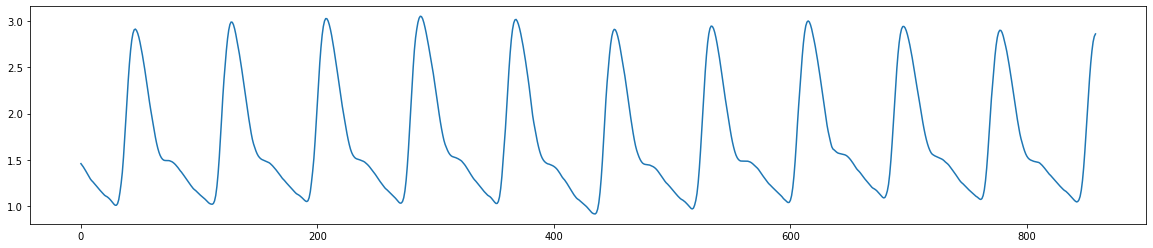

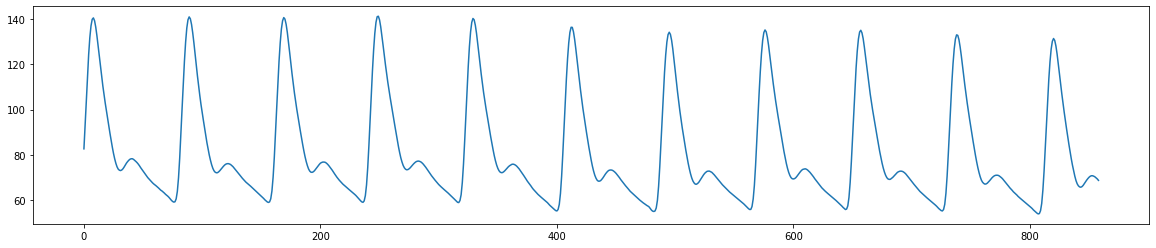

In [45]:

plt.figure(figsize=(20,4))
plt.plot(X_train[0])
plt.show()

plt.figure(figsize=(20,4))
plt.plot(blood_pressure[0])
plt.show()


####KNN Anomally Detection

here I used a module written for anomally detection in signals using the KNN algorithem

In [46]:
!pip install pyod

In [47]:
def zero_pad(dataset):
  row_lengths = []
  for row in dataset:
      row_lengths.append(len(row))

  max_length = max(row_lengths)

  for idx ,array in enumerate(dataset):
    while len(array) < max_length:
      array = np.append(array,0)
    dataset[idx] = array

  dataset = np.vstack(dataset).astype(None)
  return dataset

In [48]:
from pyod.models.knn import KNN

# contamination means atleast this percent of the data is corrupted and should be separated
clf = KNN(contamination=0.15, n_neighbors=5)
X_ = zero_pad(X_train)
clf.fit(X_)
del X_

y_train_pred = clf.labels_ 

# Outlier scores
# from my examination these scores cant be trusted since the samples have different lenghts
# and some of the perfectly good data are given bad scores simply because they have different pattern
y_train_scores = clf.decision_scores_

here I performed the algorithem on the BP signals too, just in case 
we might have some corrupted labels here too

In [49]:
# blood_pressure

clfb = KNN(contamination=0.1, n_neighbors=5)
B_ = zero_pad(blood_pressure)
clfb.fit(B_)
del B_

y_train_pred_b = clfb.labels_ 
# Outlier scores
y_train_scores_b = clfb.decision_scores_

combining the two lists

In [50]:
c = y_train_pred + y_train_pred_b
combined_list_of_abnormalities = np.where(c >= 1, 1,0)
print('total number of abnormalities found:',np.count_nonzero(combined_list_of_abnormalities==1))

total number of abnormalities found: 573


Print out found anomalis for further inspection

printed pdf could be found in the submited rar file named as 'anomaly_detection.pdf'

In [51]:
from matplotlib.backends.backend_pdf import PdfPages
plt.rcParams.update({'figure.max_open_warning': 0})

print_ = 0 # toggle to 1 if want to save the pdf

if print_ == True:
  pdf = PdfPages('anomaly_detection.pdf')
  for i,s in enumerate(combined_list_of_abnormalities):
    if s ==1:
      fig,(ax0, ax1) =  plt.subplots(2,1)
      ax0.plot(X_train[i])
      peaks, _ = find_peaks(X_train[i], height=2, distance=40)
      ax0.plot(peaks, X_train[i][peaks], "x")
      ax0.legend(['%.1f_%.1f' %(i, y_train_scores[i])], loc='lower right')

      ax1.plot(blood_pressure[i])
      ax1.legend(['%.1f_%.1f' %(i, y_train_scores_b[i])], loc='lower right')
      _, height_ = find_peaks(blood_pressure[i], height=100, distance=40)
      peaks_, _ = find_peaks(blood_pressure[i], height=height_['peak_heights'].mean()-10, distance=40)
      ax1.plot(peaks_, blood_pressure[i][peaks_], 'r')

      _, _height = find_peaks(np.negative(blood_pressure[i]), height=-90, distance=40)
      _peaks, _ = find_peaks(np.negative(blood_pressure[i]), height=_height['peak_heights'].mean()-10, distance=50)
      ax1.plot(_peaks, blood_pressure[i][_peaks], 'g')

      pdf.savefig(fig)
      plt.close(fig)
  pdf.close()

removing the mistakenly classified samples manually

In [52]:
m =[0,80,91,179,218,312,333,400,405,427,601,611,666,679,719,720,722,724,726,728,730,741,743,745,760,762,765,767,769,770,771,789,
    800,801,811,813,819,821,829,898,931,950,974,979,984,997,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,1011,1020,1029,1064,
    1190,1191,1192,1193,1194,1195,1196,1197,1198,1199,1200,1201,1236,1304,1320,1322,1327,1364,1366,1367,1372,1385,1392,1393,1394,
    1402,1406,1417,1425,1426,1428,1429,1430,1431,1432,1433,1434,1526,1577,1652,1665,1669,1675,1745,1751,1795,1865,1873,1890,1901,
    1919,1920,1946,2002,2005,2018,2030,2046,2050,2064,2069,2075,2099,2122,2134,2144,2160,2183,2186,2253,2254,2256,2258,2260,2262,
    2264,2275,2277,2279,2294,2296,2299,2301,2303,2304,2305,2309,2339,2397,2400,2419,2441,2447,2468,2471,2472,2490,2500,2511,2516,
    2550,2592,2593,2595,2644,2697,2712,2734,2736,2764,2779,2780,2843,2912,2915,2934,2956,2983,2986,3046,3061,3062,3063,3064,3066,
    3070,3071,3072,3073,3076,3078,3075,3079,3081,3083,3084,3089,3082,3086,3092,3096,3097,3098,3099,3100,3101,3102,3104,3105,3106,
    3108,3110,3103,3107,3109,3111,3113,3114,3115,3124,3125,3112,3126,3290,3292,3296,3305,3326,3352,3355,3359,3383]
for mis in m:
  combined_list_of_abnormalities[mis] = 0

visualizing couple of samples that are considered anomaly

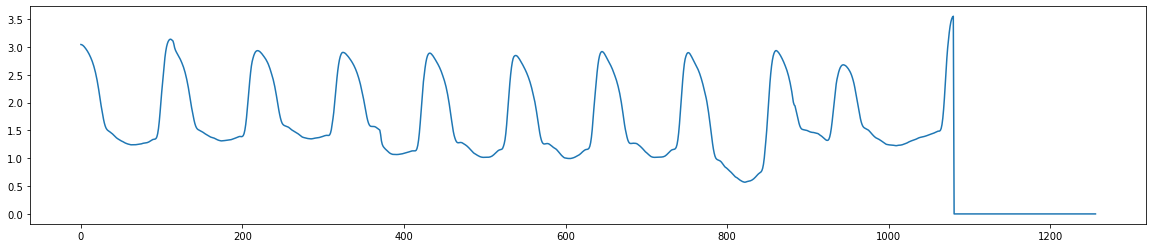

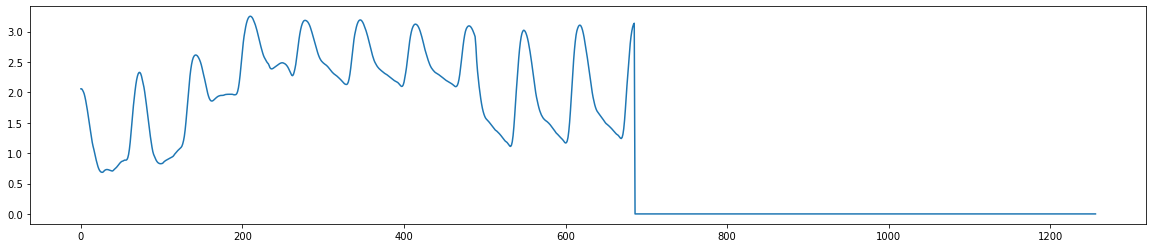

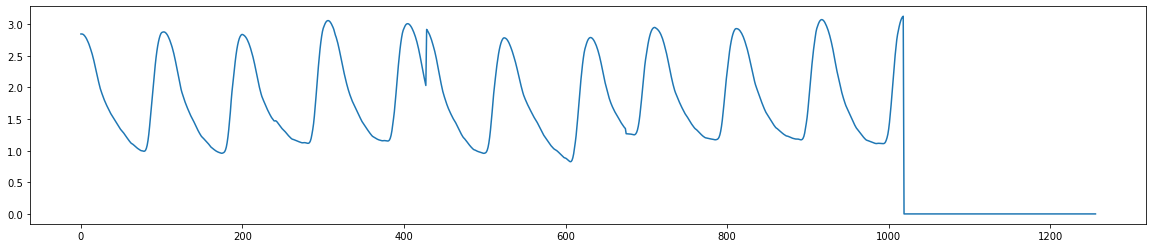

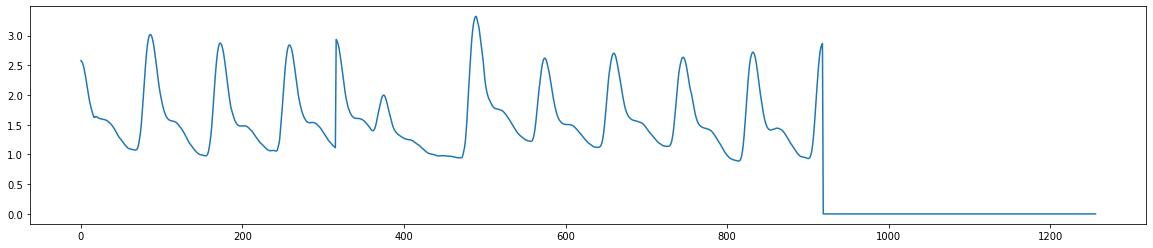

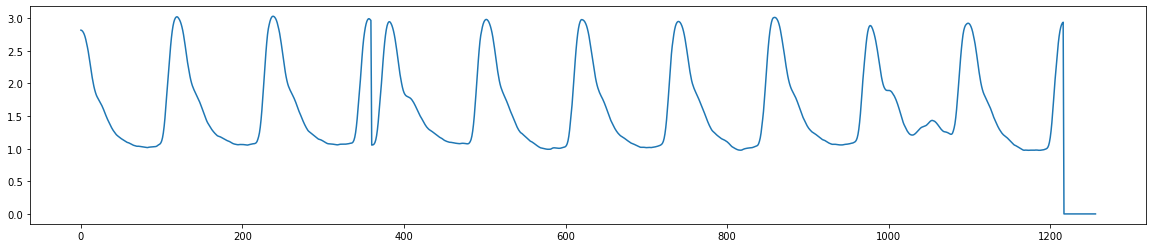

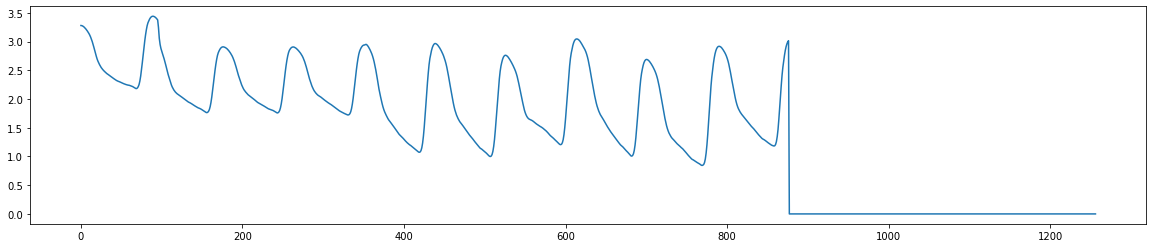

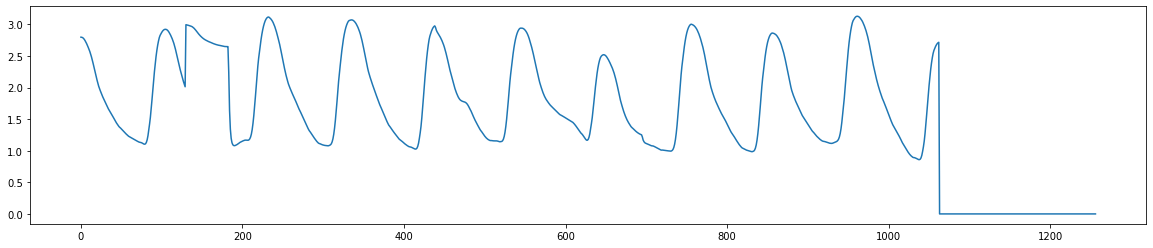

In [56]:
ran = np.random.randint(0,combined_list_of_abnormalities.shape[0],size=200)
for r in ran:
  if combined_list_of_abnormalities[r] == 1:
    plt.figure(figsize=(20,4))
    plt.plot(X_train[r])
    plt.show()

Peak detection constrain

here I imposed a limit on the peaks found in the input and label data to omit the data with lower or higher number of found peak, this might be due to noise or other issues
if the sample doesnt meet the constrain it will be labeled as an anomaly

In [62]:
for idx,_ in enumerate(X_train):
    
  peaks, _ = find_peaks(X_train[idx], height=2, distance=40)
  
  _, height_ = find_peaks(blood_pressure[idx], height=100, distance=40)
  peaks_, _ = find_peaks(blood_pressure[idx], height=height_['peak_heights'].mean()-10, distance=40)
  
  if len(peaks_) <= 9 or len(peaks_) >= 11:
    combined_list_of_abnormalities[idx] = 2
  
  _, _height = find_peaks(np.negative(blood_pressure[idx]), height=-90, distance=40)
  _peaks, _ = find_peaks(np.negative(blood_pressure[idx]), height=_height['peak_heights'].mean()-10, distance=50)

  if len(_peaks) <= 9 or len(_peaks) >= 11:
    combined_list_of_abnormalities[idx] = 2
  
print(np.count_nonzero(combined_list_of_abnormalities==2))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: Mean of empty slice.
  
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


673


visualizing couple of samples that didnt meet the peak constrain

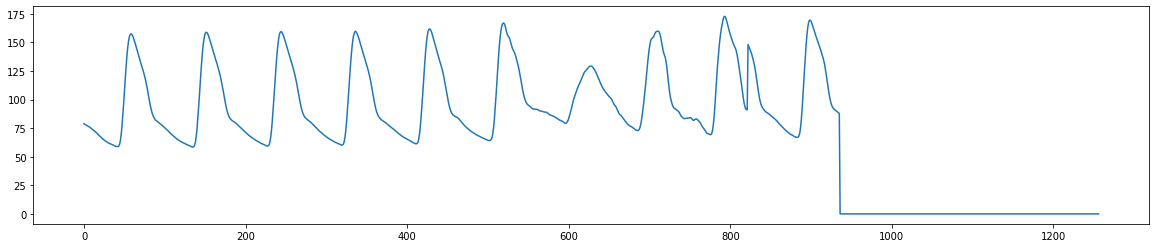

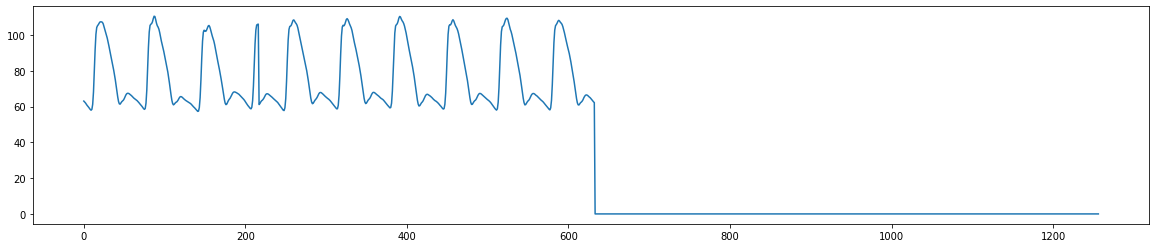

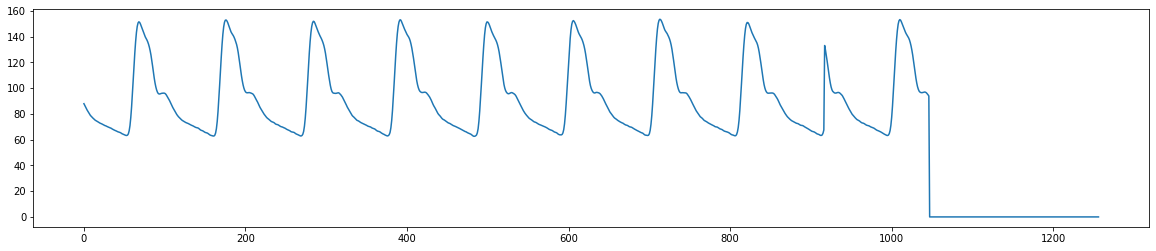

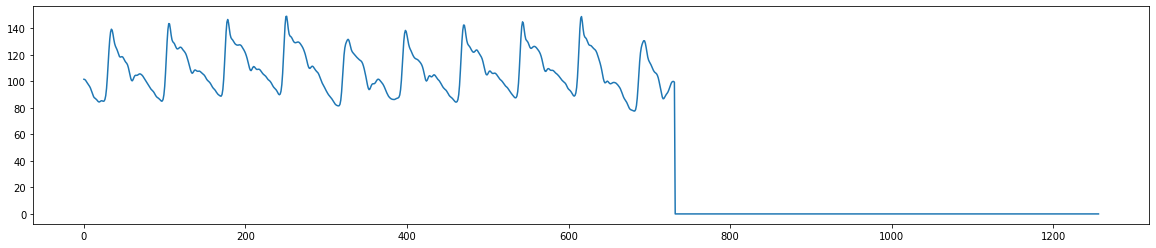

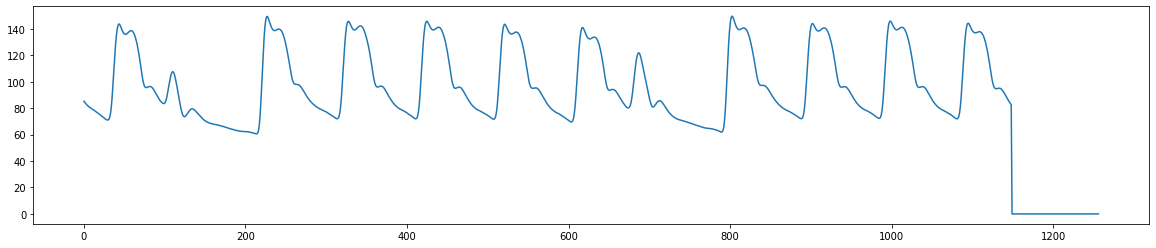

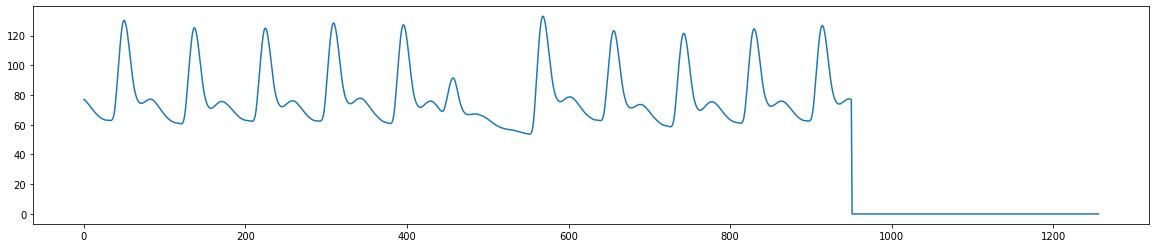

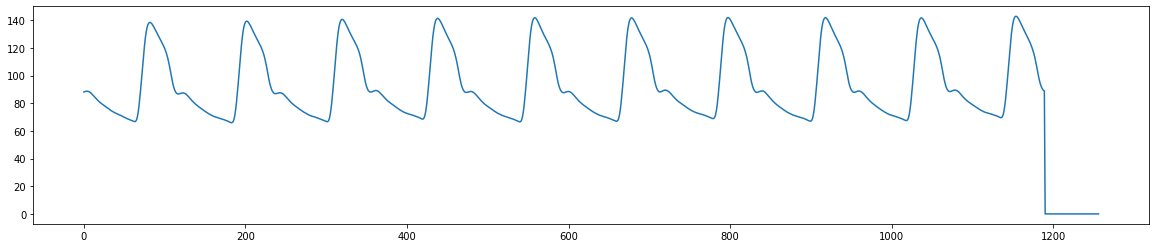

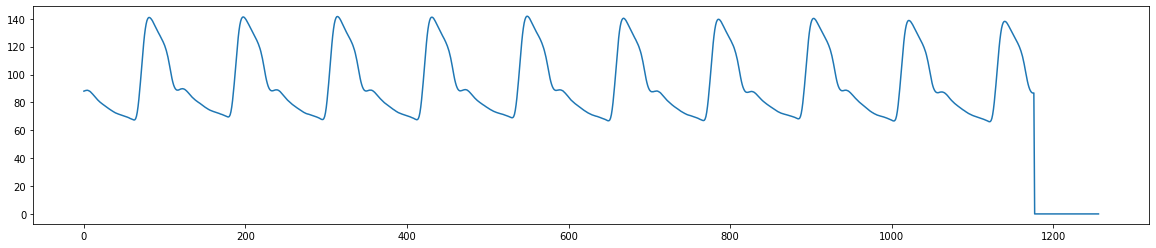

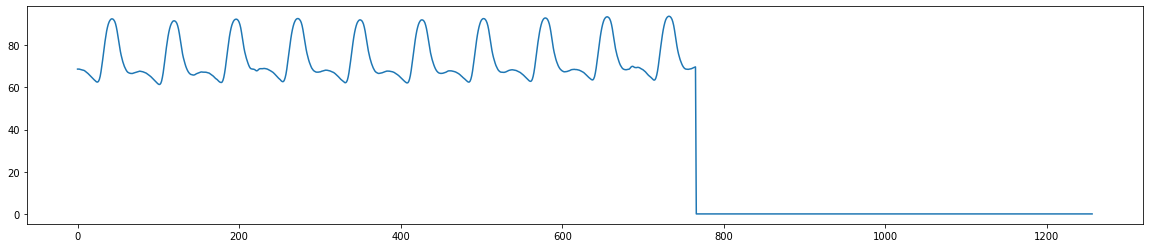

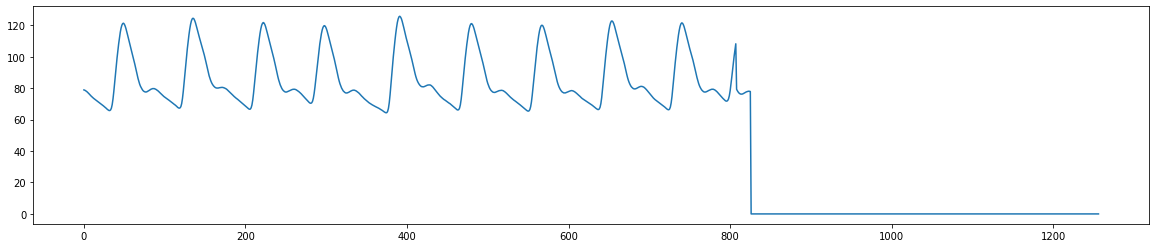

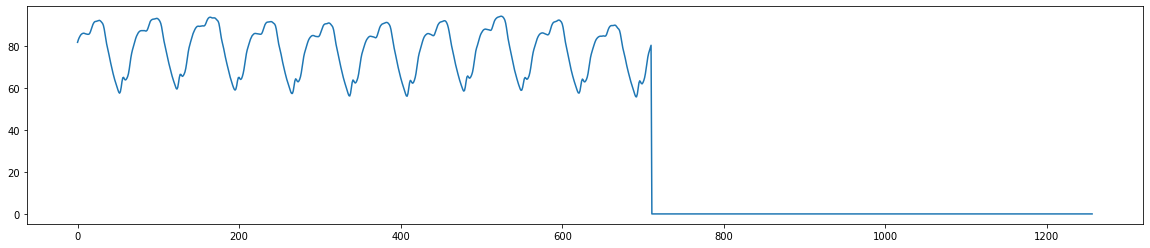

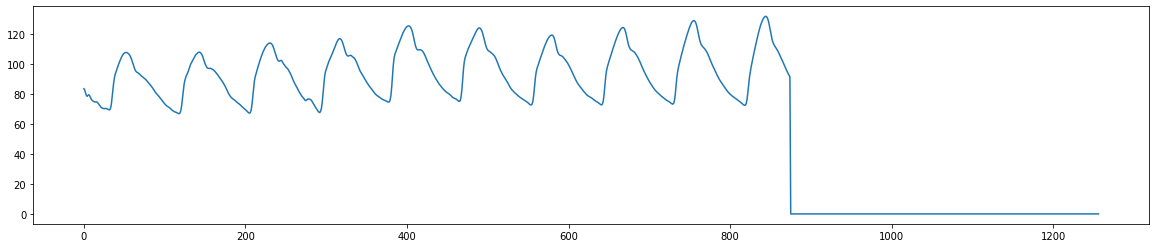

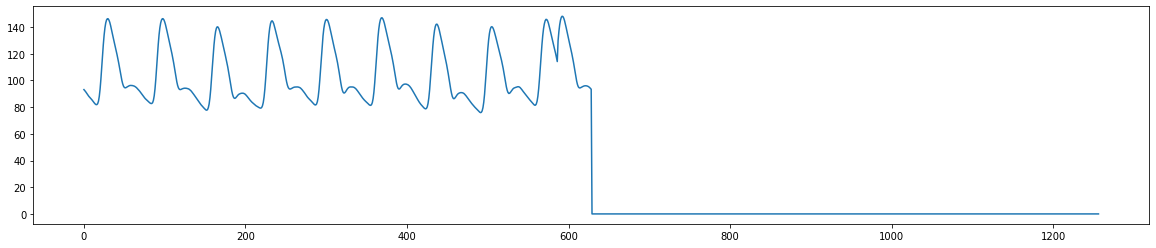

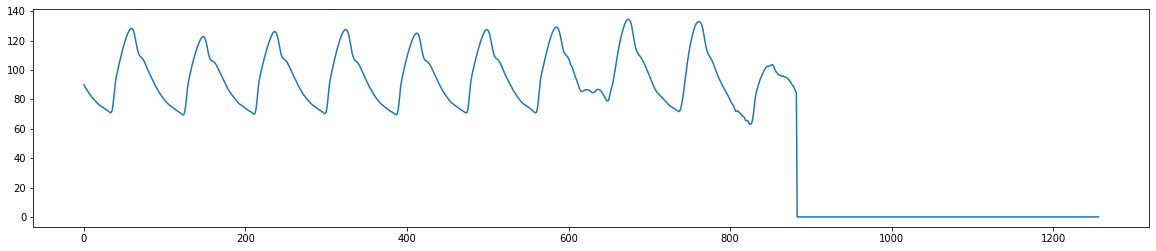

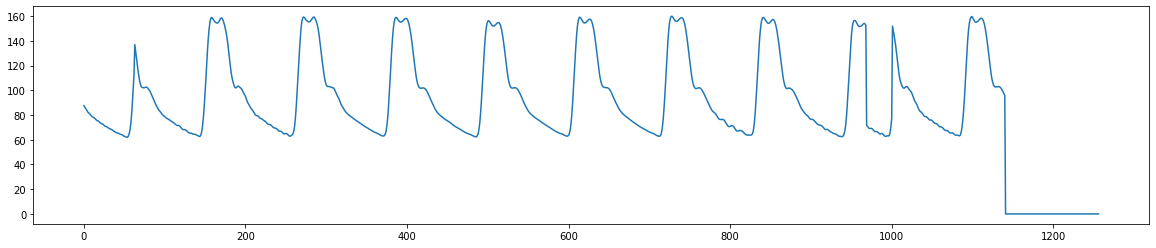

In [61]:
ran_ = np.random.randint(0,combined_list_of_abnormalities.shape[0],size=100)
for r in ran_:
  if combined_list_of_abnormalities[r] == 2:
    plt.figure(figsize=(20,4))
    plt.plot(blood_pressure[r])
    plt.show()

####Saving dataset into pdf for further manual inspection

printed pdf could be found in the submited rar file named as 'train_dataset.pdf'

In [ ]:
from matplotlib.backends.backend_pdf import PdfPages

_print = 0 # toggle to 1 if want to save the pdf

if _print == True:
  plt.rcParams.update({'figure.max_open_warning': 0})
  pdf = PdfPages('train_dataset.pdf')

  for idx,s in enumerate(combined_list_of_abnormalities):
    if s == 0:
      fig,(ax0, ax1) =  plt.subplots(2,1)

      ax0.plot(X_train[idx])

      peaks, _ = find_peaks(X_train[idx], height=2, distance=40)
      ax0.plot(peaks, X_train[idx][peaks], "x")

      ax0.set_title('PPG')
      ax0.legend(['idx:%r' %idx], loc='lower right')
      ####
      ax1.plot(blood_pressure[idx])

      _, height_ = find_peaks(blood_pressure[idx], height=100, distance=40)
      peaks_, _ = find_peaks(blood_pressure[idx], height=height_['peak_heights'].mean()-10, distance=40)
      ax1.plot(peaks_, blood_pressure[idx][peaks_], 'r')

      _, _height = find_peaks(np.negative(blood_pressure[idx]), height=-90, distance=40)
      _peaks, _ = find_peaks(np.negative(blood_pressure[idx]), height=_height['peak_heights'].mean()-10, distance=50)
      ax1.plot(_peaks, blood_pressure[idx][_peaks], 'g')

      ax1.legend(['%.1f_%.1f' %(y_diastolic_train[idx], y_systolic_train[idx])], loc='lower right')

      pdf.savefig(fig)
      plt.close(fig)

  pdf.close()

####Updating the dataset

In [ ]:
delete =[]
for i,s in enumerate(combined_list_of_abnormalities):
  if not s == 0:
    delete.append(i)

# these are handful abnormalities which wasn't found by the algorithem
delete.append(158)
delete.append(389)
delete.append(613)
delete.append(1138)
delete.append(1145)

X_train = np.delete(X_train, delete)
blood_pressure = np.delete(blood_pressure, delete)
y_systolic_train = np.delete(y_systolic_train, delete)
y_diastolic_train = np.delete(y_diastolic_train, delete)

####Baseline model

In [ ]:
# only fitting an intercept (mean of the output)

y_s = y_systolic_train.mean()
y_d = y_diastolic_train.mean()
print('systolic intercept:',y_s)
print('diastolic intercept:',y_d)

TSS_s = 0
TSS_d = 0
for i in range(len(y_systolic_train)):
  TSS_s += (y_systolic_train[i] - y_s)**2
  TSS_d += (y_diastolic_train[i] - y_d)**2

baseline_s = TSS_s/len(y_systolic_train)
baseline_d = TSS_d/len(y_systolic_train)

print('mean squared error on train data:',baseline_s)
print('mean squared error on train data:',baseline_d)

def improvement(base, new):
  print('improvement over baseline model: %.2f percent'  %((base - new)/base * 100))

systolic intercept: 134.78885362987467
diastolic intercept: 66.08295667447179
mean squared error on train data: 406.65060583809134
mean squared error on train data: 59.440540917637094


####PCA

zero-padding the data rows to have equal size

In [ ]:
X_train = zero_pad(X_train)

performing dimension reduction PCA on data

In [ ]:
from sklearn import decomposition
from sklearn.preprocessing import StandardScaler

def PCA_(data, dimension):

  data = StandardScaler().fit_transform(data)

  pca = decomposition.PCA()

  pca.n_components = dimension
  return pca.fit_transform(data)

print("shape of train data before pca= ", X_train.shape)
X_train = PCA_(X_train, 200)

print("shape of train data after pca= ", X_train.shape)


shape of train data before pca=  (2652, 1257)
shape of train data after pca=  (2652, 200)


####Nested Cross Validation Model Selection

In [ ]:
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.kernel_ridge import KernelRidge


# define polynomial regression pipeline
pipeline = make_pipeline(PolynomialFeatures(), LinearRegression())


def nested_cv(X,y,
              models_and_parameters,
              base,
              inner_cv_splits=10,
              outer_cv_splits=10):
  
  inner_cv = KFold(n_splits=inner_cv_splits, shuffle=True, random_state=1) # validation
  outer_cv = KFold(n_splits=outer_cv_splits, shuffle=True, random_state=2) # test

  average_scores_across_outer_folds_for_each_model = dict()

  # find the model with the best generalization error
  for name, (model, params) in models_and_parameters.items():
      regressor_that_optimizes_hyperparams = GridSearchCV(estimator=model,
                                                          param_grid=params,
                                                          cv=inner_cv, 
                                                          scoring='neg_mean_squared_error')

      # estimate generalization error
      scores_across_outer_folds = cross_val_score(regressor_that_optimizes_hyperparams,
                                                  X, y, cv=outer_cv, 
                                                  scoring='neg_mean_squared_error')

      # get the mean MSE across each of outer_cv's folds
      average_scores_across_outer_folds_for_each_model[name] = np.mean(scores_across_outer_folds)

      error_summary = 'Model: {name}\nMSE in the outer folds: {scores}.\nAverage error: {avg}'
      print(error_summary.format(name=name, scores=scores_across_outer_folds,
                                avg=np.mean(scores_across_outer_folds)))
      print()

  print('Average score across the outer folds: ',
        average_scores_across_outer_folds_for_each_model)

  best_model_name, best_model_avg_score = max(average_scores_across_outer_folds_for_each_model.items(),
                                            key=(lambda name_averagescore: name_averagescore[1]))

  # get the best model and its associated parameter grid
  best_model, best_model_params = models_and_parameters[best_model_name]


  final_regressor = GridSearchCV(best_model, best_model_params, cv=inner_cv)
  final_regressor.fit(X, y)

  print('Best model: \n\t{}'.format(best_model), end='\n\n')
  print('Estimation of its generalization error (negative mean squared error):\n\t{}'.format(
      best_model_avg_score), end='\n\n')
  print('Best parameter choice for this model: \n\t{params}'
        '\n(according to cross-validation `{cv}` on the whole dataset).'.format(
        params=final_regressor.best_params_, cv=inner_cv))
  
  improvement(base, - best_model_avg_score)

  return final_regressor


Systolic

In [ ]:
models_and_parameters = {
    'svr': (SVR(),
            {'C': 10**np.linspace(-3,2,7)}),
    'rforest': (RandomForestRegressor(),
            {'max_depth': [15, 28, 35]}),
    'ridge': (Ridge(),
            {'alpha': 10**np.linspace(10,-2,20)*0.5}),
    'dtree': (DecisionTreeRegressor(),
            {'max_depth': np.linspace(10,500,11, dtype=int)}),
    'gbr': (GradientBoostingRegressor(),
            {'max_depth': range(3,7),}),
    'knr': (KNeighborsRegressor(),
            {'n_neighbors': np.linspace(5,15,10, dtype=int)}),
    # 'poly': (pipeline,
    #         {'polynomialfeatures__degree': range(1,4)})
            }

final_regressor_s = nested_cv(X_train,
                              y_systolic_train,
                              models_and_parameters,
                              baseline_s,
                              3,10)

Model: svr
MSE in the outer folds: [ -81.64359451  -78.99079531  -88.25565367  -86.94593114  -93.7595796
  -73.37588578  -60.59919419  -70.72463921  -85.27593313 -103.76940383].
Average error: -82.3340610372143

Model: rforest
MSE in the outer folds: [-114.14343058 -107.62844992 -104.0606386  -104.16193113 -153.40047613
 -122.51311453  -94.88928262  -93.48972623 -130.94866334 -128.02708917].
Average error: -115.32628022480507

Model: ridge
MSE in the outer folds: [-188.55497609 -206.28149941 -187.1186137  -195.62698792 -203.249196
 -187.54888749 -152.45810725 -158.55815913 -293.74702884 -252.7876192 ].
Average error: -202.5931075024981

Model: dtree
MSE in the outer folds: [-242.71382222 -232.17114814 -198.67568678 -209.30533096 -314.29552525
 -252.03905175 -252.3482942  -179.83668418 -223.07635749 -217.98044914].
Average error: -232.2442350099337

Model: gbr
MSE in the outer folds: [-113.6984619   -93.28069577  -97.13319699  -83.03588537 -126.89552767
 -114.03203835  -90.08042242  -86

diastolic

In [40]:
final_regressor_d = nested_cv(X_train,
                              y_diastolic_train,
                              models_and_parameters,
                              baseline_d,
                              3,10)

Model: svr
MSE in the outer folds: [-11.89735572 -12.76049485 -15.23429787 -10.96551336  -9.37994291
 -13.69243365  -9.80215557 -15.35606121 -14.08679197 -12.782956  ].
Average error: -12.595800311089855

Model: rforest
MSE in the outer folds: [-23.07449405 -20.00839624 -21.92190499 -19.46715372 -17.06238369
 -26.53234579 -15.20541897 -22.75486754 -19.76780025 -18.78249577].
Average error: -20.457726100957803

Model: ridge
MSE in the outer folds: [-31.02650808 -29.73045257 -33.41632851 -29.37300282 -24.73634152
 -35.03345633 -22.72747886 -29.79983572 -31.56370993 -34.37432562].
Average error: -30.178143995651812

Model: dtree
MSE in the outer folds: [-52.10768133 -31.76437657 -37.91467254 -36.94990659 -40.54319529
 -53.53846807 -33.55505412 -40.96434564 -42.5004394  -43.91717123].
Average error: -41.375531078888784

Model: gbr
MSE in the outer folds: [-22.31791622 -15.97398358 -20.67344929 -18.48443027 -17.69531007
 -25.05219046 -16.9382113  -22.34879048 -19.02476605 -16.43777737].
Ave

####Evaluating Best Model on Test Data

preprocessing

In [ ]:
from scipy.signal import find_peaks

X_test = []
previous = 0

for s in range(ppg_test.shape[0]):
  peaks, _ = find_peaks(ppg_test[s], height=2, distance=40)
  for idx, p in enumerate(peaks):
    if idx % 10 == 0 and not idx==0:
      if idx == 10:
        previous = 0
      
      X_test.append(ppg_test[s][previous:p])
      
      previous = p

X_test = np.asarray(X_test)

X_test = zero_pad(X_test)
X_test = PCA_(X_test, 200)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Testing

In [ ]:
Systolic_predicted = final_regressor_s.predict(X_test)
print('Systolic:\n',Systolic_predicted)
np.save('Systolic_predicted.npy', Systolic_predicted)

Systolic:
 [132.35690773 143.08673739 131.83423398 136.42130935 132.3227471
 138.33591171 137.44308822 128.95910744 135.09164972 142.26390023
 136.06092676 137.49295059 128.93972936 133.53383177 136.5804881
 133.01908893 129.2781432  127.48016229 165.00473266 144.59834854
 130.63161258 136.66464396 127.15224601 128.78035051 141.79561268
 146.09352818 142.58422701 126.81284427 137.58609754 135.44699002
 122.85125332 134.86282043 132.9606361  141.62006336 138.41718573
 130.90654461 126.59698063 142.47445678 125.7933158  144.97439047
 126.44858669 137.29071101 126.18063635 146.50956502 132.24059661
 136.64249375 134.26315098 129.68721736 136.30779915 130.12776563
 163.18290245 166.80174332 148.10700705 134.9757485  137.36243836
 137.00581305 130.80298884 126.71993489 153.80569097 147.97606418
 140.25224733 137.23848922 146.75500113 127.26299202 128.78884546
 129.99864095 141.58814862 143.79886195 147.01467087 143.72710042
 155.28897494 132.83072261 131.52772689 132.43633045 135.88296252
 

In [41]:
Diastolic_predicted = final_regressor_d.predict(X_test)
print('Diastolic:\n',Diastolic_predicted)
np.save('Diastolic_predicted.npy', Diastolic_predicted)

Diastolic:
 [58.84101144 61.42839264 53.88391786 57.91834943 59.05855584 57.26276722
 61.26668397 51.09149703 62.24834592 74.9853767  58.68399085 67.84938228
 64.10535618 66.12894161 68.65211913 65.36189745 60.42835494 56.60487865
 72.97594642 65.56719394 57.28379502 57.88713553 53.84575455 56.20313773
 62.19804021 62.60259575 60.48412635 60.18516402 64.14802829 53.81965042
 47.62565429 56.2981397  61.08014514 62.16441372 64.94164551 50.83723049
 52.14378756 61.1284522  50.41574905 61.59829495 57.84863398 54.91436161
 50.87464822 62.53024654 58.93182803 58.49224607 59.92990119 58.57121661
 57.36415564 54.16144633 73.16981506 73.13028706 62.8173326  60.92774898
 62.63084932 62.6970985  54.23618326 60.4303549  68.92342995 59.09258044
 62.53244771 62.10775621 65.34926845 52.42541095 50.87308947 56.00774211
 60.90241914 60.88679199 62.91759497 65.62277754 74.32285251 71.288869
 69.44654289 71.58186078 71.7905511  68.16473141 61.84709421 61.69393064
 67.77067051 73.6048144  68.4915453  66.8